In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('D:/PycharmProjects/AB_NYC_2019.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [3]:
#drop useless columns
data = data.drop(columns=['id','name','host_id','host_name','last_review'])

In [4]:
#check missing values
data.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [5]:
#drop columns with too many missing values
data = data.drop('reviews_per_month',axis=1)

In [6]:
numeric = data.select_dtypes(include='number')
numeric.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,327.000000,365.000000


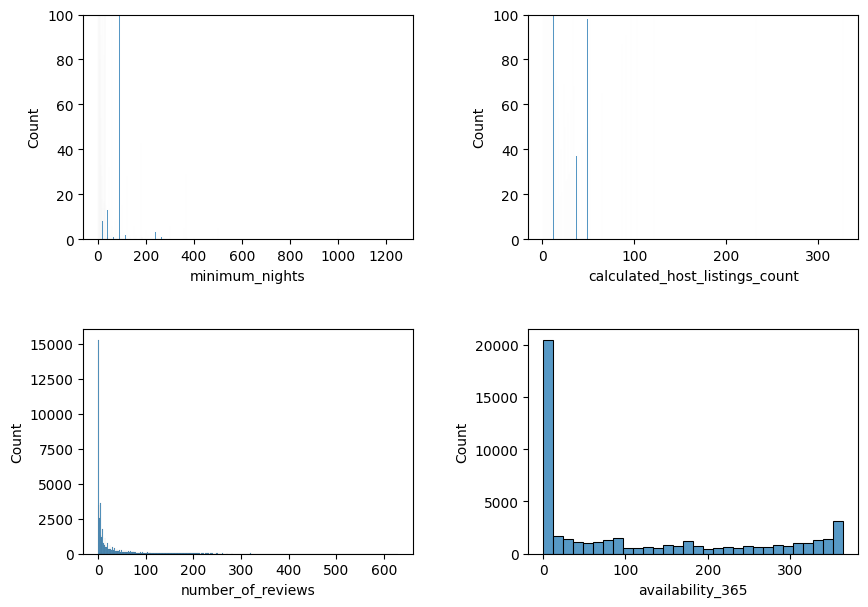

In [9]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(10, 7))

sns.histplot(data=data, x='minimum_nights',ax=axes[0][0])
axes[0][0].set_ylim(0,100)
sns.histplot(data=data, x='number_of_reviews',ax=axes[1][0])
sns.histplot(data=data, x='calculated_host_listings_count',ax=axes[0][1])
axes[0][1].set_ylim(0,100)
sns.histplot(data=data, x='availability_365',ax=axes[1][1])

fig.subplots_adjust(wspace=0.35,hspace=0.4)

<Axes: >

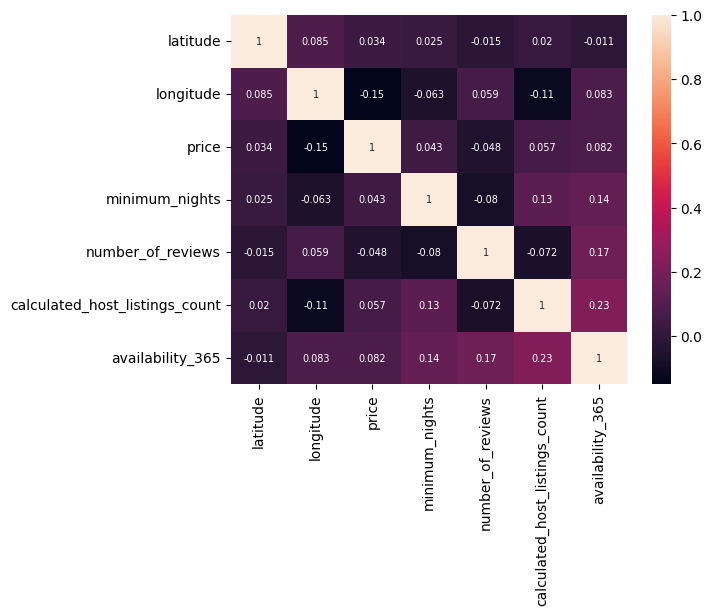

In [10]:
cor_mat = numeric.corr()
sns.heatmap(cor_mat,annot=True,annot_kws={"size": 7},)

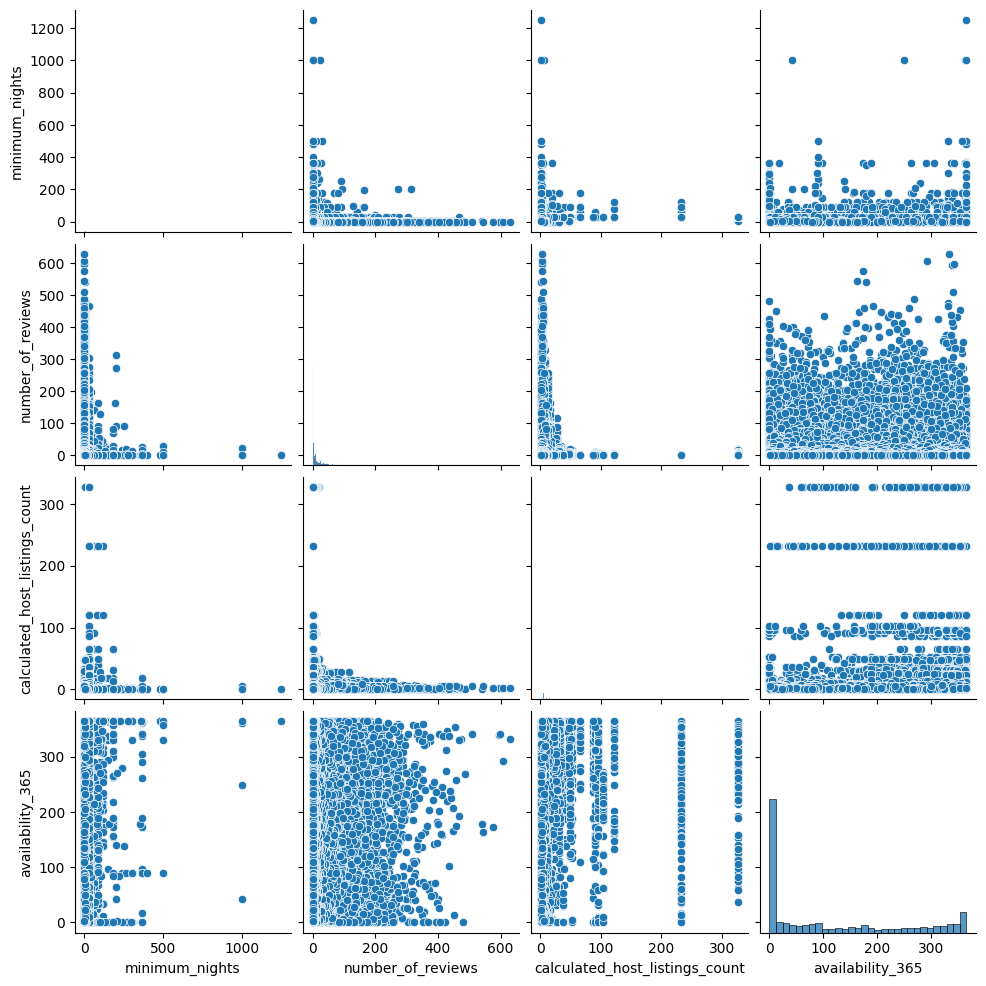

In [11]:
numeric_features = numeric.iloc[:,3:]
sns.pairplot(numeric_features)

### Вывод - можно видеть, что численные признаки практически не коррелируют друг с другом

(0.0, 250.0)

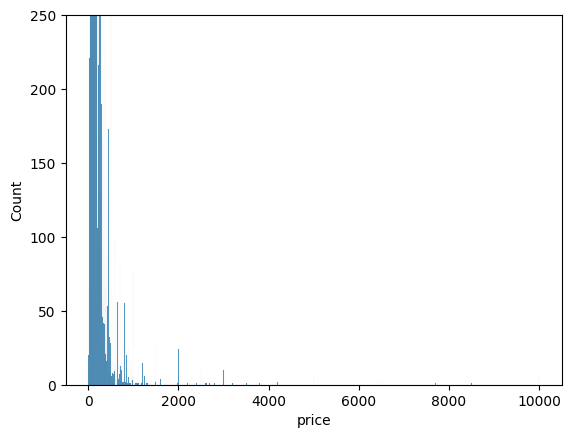

In [12]:
sns.histplot(x=data['price'])
plt.ylim(0,250)

In [7]:
#удалим образцы, в которых цена дома превышает 2000
data_reduce = data[data['price']<2000]

### построим модели с one-hot encoding и без добавления новых признаков

In [129]:
data_cat = data_reduce.select_dtypes(include='object')
data_cat_enc = pd.get_dummies(data_cat).astype(int)

numeric_features = data_reduce.select_dtypes(include='number').iloc[:,3:]

X = pd.concat([numeric_features, data_cat_enc], axis=1)
y = data_reduce['price']

In [130]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

num_cols = ['minimum_nights','number_of_reviews','calculated_host_listings_count','availability_365']
X_train_num = X_train[num_cols]
X_train = X_train.drop(columns=num_cols)
X_test_num = X_test[num_cols]
X_test = X_test.drop(columns=num_cols)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_num))
X_train_scaled = X_train_scaled.set_index(X_train_num.index)
X_train_scaled.columns = num_cols
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num))
X_test_scaled = X_test_scaled.set_index(X_test_num.index)
X_test_scaled.columns = num_cols

X_train_scaled = pd.concat([X_train_scaled,X_train],axis=1)
X_test_scaled = pd.concat([X_test_scaled,X_test],axis=1)

In [131]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

param_grid = {'alpha':[0.001,0.1,1,10,100]}
model_ridge = GridSearchCV(Ridge(),param_grid,cv=5,scoring='neg_mean_squared_error')
model_ridge.fit(X_train_scaled,y_train)
best_ridge = model_ridge.best_estimator_
ridge_pred = best_ridge.predict(X_test_scaled)
rmse_ridge = np.sqrt(mean_squared_error(y_test, ridge_pred))
r2_ridge = r2_score(y_test,ridge_pred)

In [132]:
print(f'rmse_ridge: {rmse_ridge: .3f}\nr2_ridge: {r2_ridge: .3f}')

rmse_ridge:  113.963
r2_ridge:  0.287


In [8]:
def coef_import(model,X):
    coefs = model.coef_

    feature_names = X.columns 
    
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
    coef_df['AbsCoef'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values(by='AbsCoef', ascending=False)
    coef_df = coef_df[:15]
    
    plt.figure(figsize=(10, 6))
    plt.barh(coef_df['Feature'], coef_df['AbsCoef'], color='skyblue')

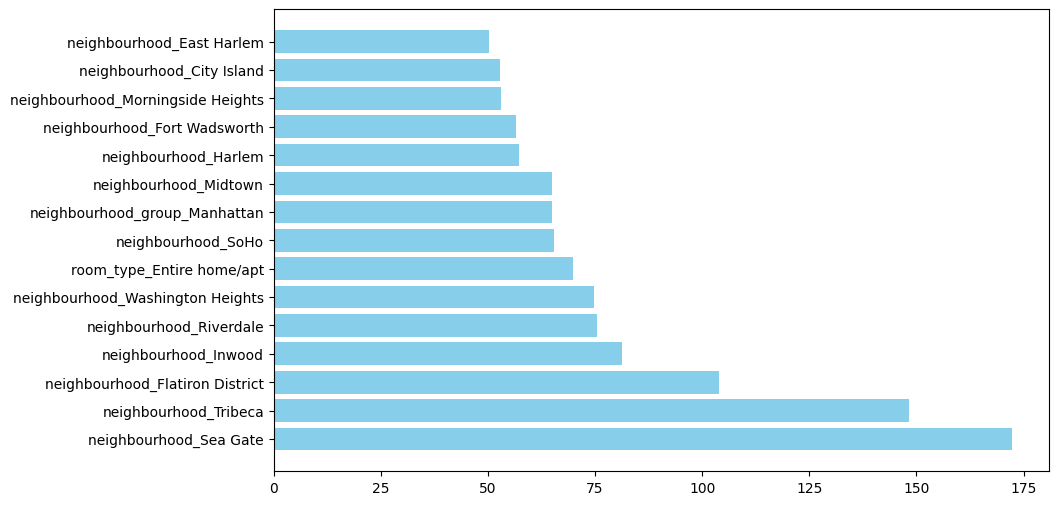

In [141]:
coef_import(best_ridge,X_train_scaled)

In [62]:
param_grid = {'alpha':[0.001,0.1,1,10,100]}
model_lasso = GridSearchCV(Lasso(),param_grid,cv=5,scoring='neg_mean_squared_error')
model_lasso.fit(X_train_scaled,y_train)
best_lasso = model_lasso.best_estimator_
lasso_pred = best_lasso.predict(X_test_scaled)
rmse_lasso = np.sqrt(mean_squared_error(y_test, lasso_pred))
r2_lasso = r2_score(y_test,lasso_pred)

C:\Users\anastasia.golubova\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.735e+07, tolerance: 4.806e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\anastasia.golubova\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.829e+07, tolerance: 4.830e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\anastasia.golubova\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase 

In [72]:
print(f'rmse_lasso: {rmse_lasso: .3f}\nr2_lasso: {r2_lasso: .3f}')

rmse_lasso:  114.277
r2_lasso:  0.283


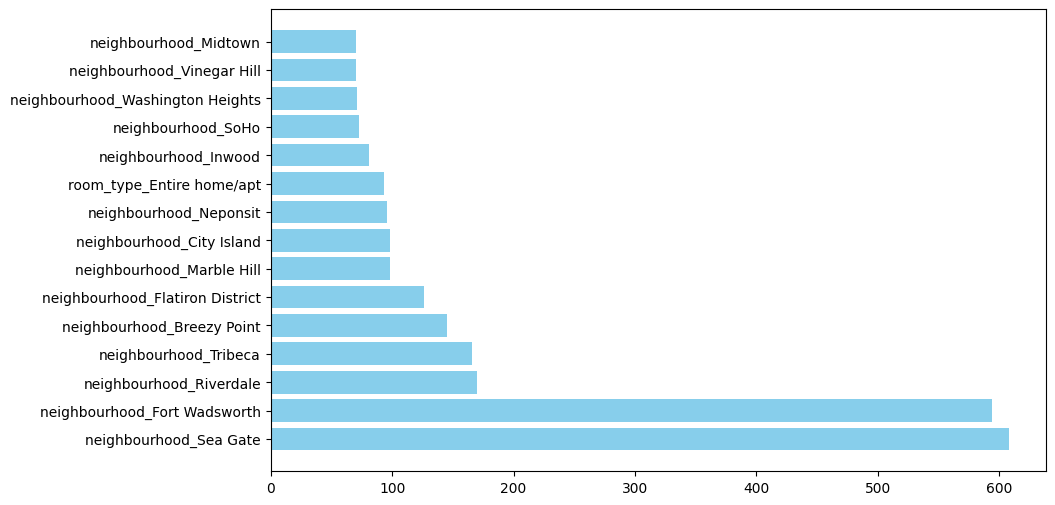

In [142]:
coef_import(best_lasso,X_train_scaled)

In [143]:
param_grid = {
    'alpha': [0.01, 1, 10],       
    'l1_ratio': [0.1, 0.5, 1]  
}
model_elastic = GridSearchCV(ElasticNet(max_iter=1000),param_grid,cv=5,scoring='neg_mean_squared_error')
model_elastic.fit(X_train_scaled,y_train)
best_el = model_elastic.best_estimator_
el_pred = best_el.predict(X_test_scaled)
rmse_el = np.sqrt(mean_squared_error(y_test, el_pred))
r2_el = r2_score(y_test,el_pred)

In [144]:
print(f'rmse_el: {rmse_el: .3f}\nr2_el: {r2_el: .3f}')

rmse_el:  114.196
r2_el:  0.284


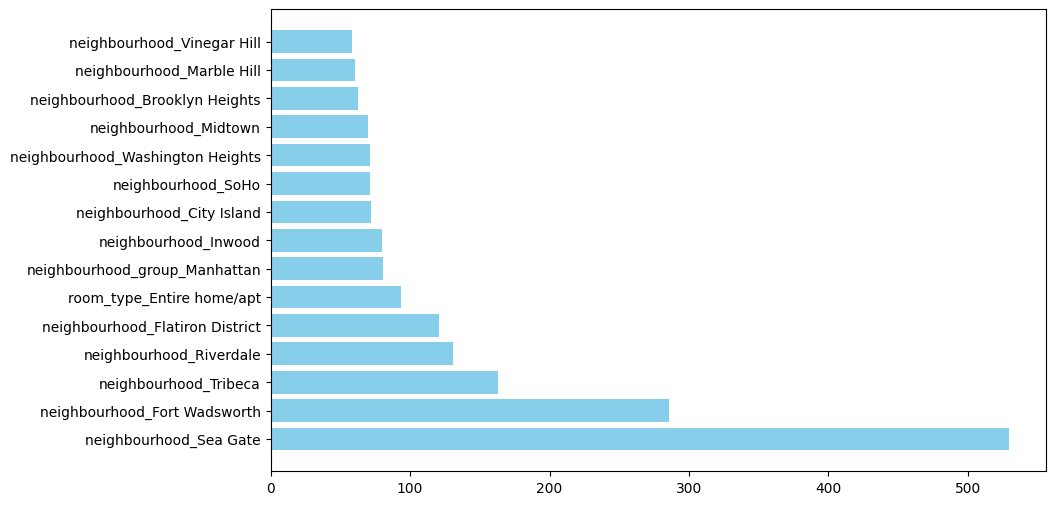

In [145]:
coef_import(best_el,X_train_scaled)

### добавим новый признак - расстояние от жилья до самого дорогого района

In [12]:
manhattan_center = (40.7831, -73.9712)

data_reduce['Dist_to_Manhatten'] = np.sqrt(
    (data_reduce['latitude'] - manhattan_center[0])**2 +
    (data_reduce['longitude'] - manhattan_center[1])**2
)

C:\Users\anastasia.golubova\AppData\Local\Temp\ipykernel_6680\1107079491.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reduce['Dist_to_Manhatten'] = np.sqrt(


In [13]:
data_cat = data_reduce.select_dtypes(include='object')
data_cat_enc = pd.get_dummies(data_cat).astype(int)

num_cols = ['minimum_nights','number_of_reviews','calculated_host_listings_count','availability_365','Dist_to_Manhatten']
numeric_features = data_reduce[num_cols]

X = pd.concat([numeric_features, data_cat_enc], axis=1)
y = data_reduce['price']

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

X_train_num = X_train[num_cols]
X_train = X_train.drop(columns=num_cols)
X_test_num = X_test[num_cols]
X_test = X_test.drop(columns=num_cols)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_num))
X_train_scaled = X_train_scaled.set_index(X_train_num.index)
X_train_scaled.columns = num_cols
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num))
X_test_scaled = X_test_scaled.set_index(X_test_num.index)
X_test_scaled.columns = num_cols

X_train_scaled = pd.concat([X_train_scaled,X_train],axis=1)
X_test_scaled = pd.concat([X_test_scaled,X_test],axis=1)

In [26]:
param_grid = {'alpha':[0.001,0.1,1,10,100]}
model_ridge = GridSearchCV(Ridge(),param_grid,cv=5,scoring='neg_mean_squared_error')
model_ridge.fit(X_train_scaled,y_train)
best_ridge = model_ridge.best_estimator_
ridge_pred = best_ridge.predict(X_test_scaled)
rmse_ridge = np.sqrt(mean_squared_error(y_test, ridge_pred))
r2_ridge = r2_score(y_test,ridge_pred)

In [27]:
print(f'rmse_ridge: {rmse_ridge: .3f}\nr2_ridge: {r2_ridge: .3f}')

rmse_ridge:  113.932
r2_ridge:  0.288


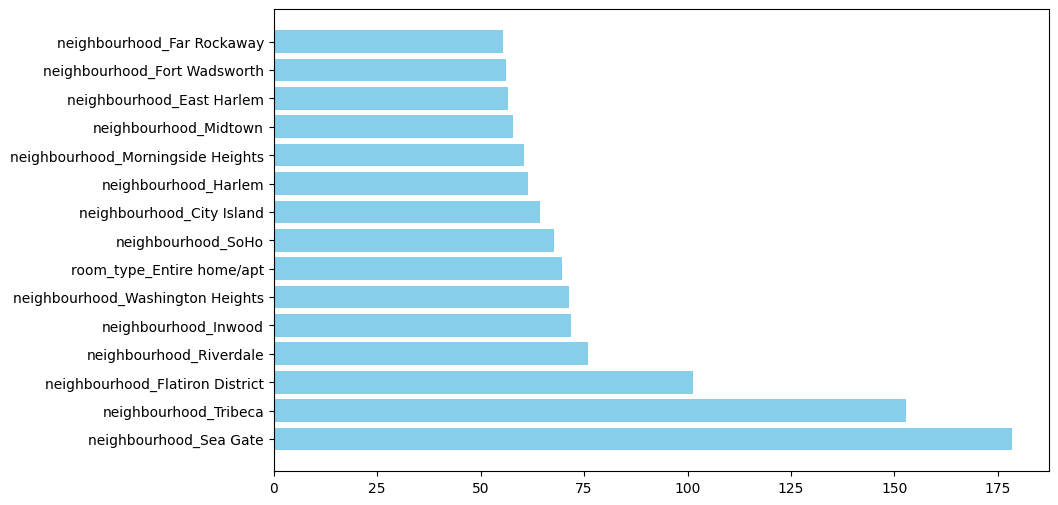

In [28]:
coef_import(best_ridge,X_train_scaled)

In [29]:
param_grid = {'alpha':[0.001,0.1,1,10,100]}
model_lasso = GridSearchCV(Lasso(max_iter=1000),param_grid,cv=5,scoring='neg_mean_squared_error')
model_lasso.fit(X_train_scaled,y_train)
best_lasso = model_lasso.best_estimator_
lasso_pred = best_lasso.predict(X_test_scaled)
rmse_lasso = np.sqrt(mean_squared_error(y_test, lasso_pred))
r2_lasso = r2_score(y_test,lasso_pred)

C:\Users\anastasia.golubova\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.207e+05, tolerance: 4.806e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\anastasia.golubova\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.711e+06, tolerance: 4.887e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\anastasia.golubova\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase 

In [30]:
print(f'rmse_lasso: {rmse_lasso: .3f}\nr2_lasso: {r2_lasso: .3f}')

rmse_lasso:  114.197
r2_lasso:  0.284


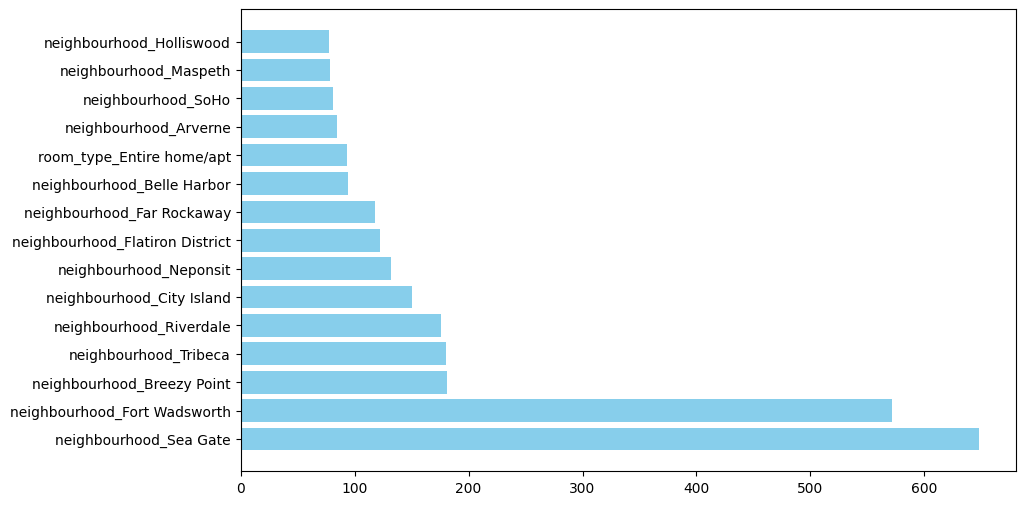

In [33]:
coef_import(best_lasso,X_train_scaled)

In [31]:
param_grid = {
    'alpha': [0.01, 1, 10],       
    'l1_ratio': [0.1, 0.5, 1]  
}
model_elastic = GridSearchCV(ElasticNet(max_iter=1000),param_grid,cv=5,scoring='neg_mean_squared_error')
model_elastic.fit(X_train_scaled,y_train)
best_el = model_elastic.best_estimator_
el_pred = best_el.predict(X_test_scaled)
rmse_el = np.sqrt(mean_squared_error(y_test, el_pred))
r2_el = r2_score(y_test,el_pred)

In [32]:
print(f'rmse_el: {rmse_el: .3f}\nr2_el: {r2_el: .3f}')

rmse_el:  114.185
r2_el:  0.284


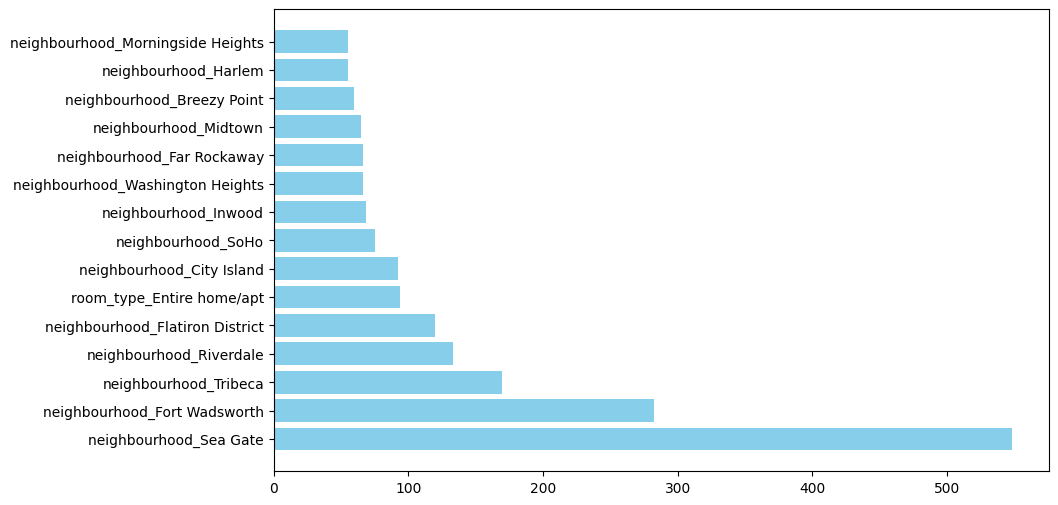

In [25]:
coef_import(best_el,X_train_scaled)

### Дополнительно посмотрим на модель с лучшим результатом (Ridge)

In [62]:
coefs = best_ridge.coef_

feature_names = X.columns 
    
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
coef_df['AbsCoef'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='AbsCoef', ascending=False)
coef_df = coef_df[:15]

In [63]:
coef_df['Neigh'] = coef_df['Feature'].str.split('_').str[1]
coef_df = coef_df.drop(columns='Feature')
df_unique = data_reduce.drop_duplicates(subset='neighbourhood', keep='first')
merged_features = coef_df.merge(df_unique, left_on='Neigh',right_on='neighbourhood')

In [64]:
merged_features

,Coefficient,AbsCoef,Neigh,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,Dist_to_Manhatten
0,178.372902,178.372902,Sea Gate,Brooklyn,Sea Gate,40.57645,-74.01065,Entire home/apt,1485,2,6,1,260,0.210382
1,152.787882,152.787882,Tribeca,Manhattan,Tribeca,40.71193,-74.00817,Private room,150,3,82,2,90,0.080199
2,101.271868,101.271868,Flatiron District,Manhattan,Flatiron District,40.74030,-73.98498,Entire home/apt,305,2,108,1,201,0.044964
3,76.034903,76.034903,Riverdale,Bronx,Riverdale,40.88579,-73.91599,Entire home/apt,250,7,2,1,338,0.116591
4,-71.872535,71.872535,Inwood,Manhattan,Inwood,40.86754,-73.92639,Private room,80,4,0,1,0,0.095593
5,-71.359789,71.359789,Washington Heights,Manhattan,Washington Heights,40.83139,-73.94095,Private room,65,2,49,2,336,0.056982
6,67.844866,67.844866,SoHo,Manhattan,SoHo,40.72210,-73.99775,Entire home/apt,180,30,21,1,154,0.066527
7,64.266470,64.266470,City Island,Bronx,City Island,40.85235,-73.78873,Entire home/apt,84,3,67,1,0,0.195169
8,-61.513600,61.513600,Harlem,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365,0.039120
9,-60.431276,60.431276,Morningside Heights,Manhattan,Morningside Heights,40.80549,-73.95924,Private room,99,4,122,2,233,0.025384


### Вывод - наилучший результат показала Ridge регрессия, однако добавление нового признака (расстояние до самого дорогого района) не помогло значительно улучшить метрики. Среди наиболее важных признаков оказались районы, в котором находится жилье, бОльшая часть из которых относится к округу Манхэттена. 